In [1]:
import os

DATASET_PATH = r"C:\Users\Admin\multispectral_image_dehazing\Data_for_dehazing model\unpaired_data"
print("Dataset exists:", os.path.exists(DATASET_PATH))
print("Folders inside:", os.listdir(DATASET_PATH) if os.path.exists(DATASET_PATH) else "Path does not exist")


Dataset exists: True
Folders inside: ['test', 'train', 'validation']


In [2]:
import tensorflow as tf
print(tf.__version__)  # Should be >= 2.0.0
print("GPU detected:", tf.test.is_gpu_available())  # Deprecated in TF 2.1+, but works in older 2.x

2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU detected: True


In [10]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

tf.debugging.set_log_device_placement(True)


TensorFlow Version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Correct method

# Enable memory growth (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU details:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found!")

Num GPUs Available:  1
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
import tensorflow as tf
import os


# Check if a directory exists and contains images
def check_directory_exists(directory):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"❌ Directory not found: {directory}")
    elif not os.listdir(directory):
        raise FileNotFoundError(f"⚠️ No files found in directory: {directory}")

# Define dataset paths
DATASET_PATH = r"C:\Users\Admin\multispectral_image_dehazing\Data_for_dehazing model\unpaired_data"

IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 16

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use tf.image.decode_png for PNG images
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

# Function to create a TensorFlow dataset from a directory
def create_dataset(directory, shuffle=True):
    try:
        check_directory_exists(directory)  # Ensure directory exists and is not empty
    except FileNotFoundError as e:
        print(e)
        return None
    
    image_paths = tf.data.Dataset.list_files(os.path.join(directory, "*"), shuffle=shuffle)
    dataset = image_paths.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()  # Caching for better performance
    return dataset

# Dataset Paths
Hazed_train_path = os.path.join(DATASET_PATH, "train", "Hazed")
Dehazed_train_path = os.path.join(DATASET_PATH, "train", "Dehazed")
Hazed_val_path = os.path.join(DATASET_PATH, "validation", "Hazed")
Dehazed_val_path = os.path.join(DATASET_PATH, "validation", "Dehazed")
Hazed_test_path = os.path.join(DATASET_PATH, "test", "Hazed")
Dehazed_test_path = os.path.join(DATASET_PATH, "test", "Dehazed")

# Create datasets
Hazed_train_ds = create_dataset(Hazed_train_path, shuffle=True)
Dehazed_train_ds = create_dataset(Dehazed_train_path, shuffle=True)
Hazed_val_ds = create_dataset(Hazed_val_path, shuffle=False)  # No need to shuffle validation/test data
Dehazed_val_ds = create_dataset(Dehazed_val_path, shuffle=False)
Hazed_test_ds = create_dataset(Hazed_test_path, shuffle=False)
Dehazed_test_ds = create_dataset(Dehazed_test_path, shuffle=False)

# Checking dataset structure
dataset_names = [
    "Hazed Train", "Dehazed Train", "Hazed Validation", 
    "Dehazed Validation", "Hazed Test", "Dehazed Test"
]

datasets = [
    Hazed_train_ds, Dehazed_train_ds, Hazed_val_ds, 
    Dehazed_val_ds, Hazed_test_ds, Dehazed_test_ds
]

for name, dataset in zip(dataset_names, datasets):
    if dataset is not None:
        for image_batch in dataset.take(1):
            print(f"✅ {name} Batch Shape: {image_batch.shape}")
    else:
        print(f"⚠️ {name} dataset is missing or empty.")


✅ Hazed Train Batch Shape: (16, 256, 256, 3)
✅ Dehazed Train Batch Shape: (16, 256, 256, 3)
✅ Hazed Validation Batch Shape: (16, 256, 256, 3)
✅ Dehazed Validation Batch Shape: (16, 256, 256, 3)
✅ Hazed Test Batch Shape: (16, 256, 256, 3)
✅ Dehazed Test Batch Shape: (16, 256, 256, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters, kernel_size=3):
    res = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, res])
    return x

def build_generator(input_shape=(256, 256, 3), num_residual_blocks=6):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution block
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Downsampling
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, 256)
    
    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Output layer
    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)
    
    return Model(inputs, outputs, name="Generator")

# Instantiate generators for both directions:
generator_G = build_generator()  # Translates Hazed -> Dehazed
generator_F = build_generator()  # Translates Dehazed -> Hazed

generator_G.summary()
generator_F.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [8]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Final output layer - PatchGAN
    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs, outputs, name="Discriminator")

# Instantiate discriminators for both domains:
discriminator_X = build_discriminator()  # For Hazed images (domain X)
discriminator_Y = build_discriminator()  # For Dehazed images (domain Y)

discriminator_X.summary()
discriminator_Y.summary()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_34 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                     

In [9]:
# Define loss functions
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = (real_loss + generated_loss) * 0.5
    return total_disc_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

def identity_loss(real_image, same_image, lambda_identity=5):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * loss

# Optimizers for generators and discriminators
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [14]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [11]:
import tensorflow as tf
from tqdm import tqdm
import os

# Define checkpoint directory
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define checkpoint manager
checkpoint = tf.train.Checkpoint(
    generator_G=generator_G, generator_F=generator_F, 
    discriminator_X=discriminator_X, discriminator_Y=discriminator_Y, 
    generator_G_optimizer=generator_G_optimizer, generator_F_optimizer=generator_F_optimizer, 
    discriminator_X_optimizer=discriminator_X_optimizer, discriminator_Y_optimizer=discriminator_Y_optimizer,
    epoch=tf.Variable(0)  # Track the current epoch
)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# Restore from checkpoint if available
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Restored from checkpoint:", manager.latest_checkpoint)
    start_epoch = checkpoint.epoch.numpy()  # Start from the saved epoch
else:
    start_epoch = 0  # Start from epoch 0 if no checkpoint exists

# @tf.function is used to speed up the training step
@tf.function
def train_step(real_X, real_Y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y, and F translates Y -> X.
        fake_Y = generator_G(real_X, training=True)
        fake_X = generator_F(real_Y, training=True)
        
        # Cycle: X -> Y -> X and Y -> X -> Y
        cycled_X = generator_F(fake_Y, training=True)
        cycled_Y = generator_G(fake_X, training=True)
        
        # Identity mappings (optional)
        same_X = generator_F(real_X, training=True)
        same_Y = generator_G(real_Y, training=True)
        
        # Discriminator outputs
        disc_real_X = discriminator_X(real_X, training=True)
        disc_real_Y = discriminator_Y(real_Y, training=True)
        disc_fake_X = discriminator_X(fake_X, training=True)
        disc_fake_Y = discriminator_Y(fake_Y, training=True)
        
        # Calculate losses for generators and cycle consistency
        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)
        total_cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)
        
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_Y, same_Y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_X, same_X)
        
        # Calculate discriminator losses
        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)
    
    # Calculate the gradients for generators and discriminators
    generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    
    # Apply the gradients using the optimizers
    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))
    
    return {
        "gen_G_loss": total_gen_G_loss,
        "gen_F_loss": total_gen_F_loss,
        "disc_X_loss": disc_X_loss,
        "disc_Y_loss": disc_Y_loss
    }

# Set number of epochs
EPOCHS = 10

# Outer progress bar for epochs
for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs", unit="epoch"):
    # Dictionary to accumulate loss sums for the epoch (optional, for averaging)
    epoch_losses = {"gen_G_loss": 0.0, "gen_F_loss": 0.0, "disc_X_loss": 0.0, "disc_Y_loss": 0.0}
    num_batches = 0

    # Inner progress bar for batches in the current epoch.
    for real_X, real_Y in tqdm(tf.data.Dataset.zip((Hazed_train_ds, Dehazed_train_ds)), desc="Batches", leave=False):
        losses = train_step(real_X, real_Y)
        # Accumulate losses
        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        num_batches += 1

    # Compute average losses for the epoch
    avg_losses = {key: float(val) / num_batches for key, val in epoch_losses.items()}
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS} Losses: {avg_losses}")
    
    # Save checkpoint after each epoch
    checkpoint.epoch.assign(epoch + 1)  # Increment the epoch
    manager.save()
    print(f"Checkpoint saved at epoch {epoch+1}")

# After training, save the generator model (Hazed -> Dehazed)
generator_G.save("Nilesh_cycleGAN_dehaze.h5")
print("Model saved successfully.")


Epochs:   0%|                                                              | 0/10 [00:32<?, ?epoch/s]


ResourceExhaustedError: Graph execution error:

Detected at node 'Generator/conv2d_transpose_3/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_19628\3617966876.py", line 91, in <module>
      losses = train_step(real_X, real_Y)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_19628\3617966876.py", line 33, in train_step
      fake_X = generator_F(real_Y, training=True)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\Admin\anaconda3\envs\aitf_env\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'Generator/conv2d_transpose_3/conv2d_transpose'
OOM when allocating tensor with shape[16,256,256,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Generator/conv2d_transpose_3/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_20162]

In [13]:
generator_G.save("Nilesh_cycleGAN_dehaze.keras")

In [13]:
import tensorflow as tf
from tqdm import tqdm
import os

# Define checkpoint directory
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define checkpoint manager
checkpoint = tf.train.Checkpoint(
    generator_G=generator_G, generator_F=generator_F, 
    discriminator_X=discriminator_X, discriminator_Y=discriminator_Y, 
    generator_G_optimizer=generator_G_optimizer, generator_F_optimizer=generator_F_optimizer, 
    discriminator_X_optimizer=discriminator_X_optimizer, discriminator_Y_optimizer=discriminator_Y_optimizer,
    epoch=tf.Variable(0)  # Track the current epoch
)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# Restore from checkpoint if available
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Restored from checkpoint:", manager.latest_checkpoint)
    start_epoch = checkpoint.epoch.numpy()  # Continue from the saved epoch
else:
    start_epoch = 0  # Start from epoch 0 if no checkpoint exists

# Set number of epochs (continue training)
EPOCHS = start_epoch + 4  # Continue training for 4 more epochs

# @tf.function is used to speed up the training step
@tf.function
def train_step(real_X, real_Y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y, and F translates Y -> X.
        fake_Y = generator_G(real_X, training=True)
        fake_X = generator_F(real_Y, training=True)
        
        # Cycle: X -> Y -> X and Y -> X -> Y
        cycled_X = generator_F(fake_Y, training=True)
        cycled_Y = generator_G(fake_X, training=True)
        
        # Identity mappings (optional)
        same_X = generator_F(real_X, training=True)
        same_Y = generator_G(real_Y, training=True)
        
        # Discriminator outputs
        disc_real_X = discriminator_X(real_X, training=True)
        disc_real_Y = discriminator_Y(real_Y, training=True)
        disc_fake_X = discriminator_X(fake_X, training=True)
        disc_fake_Y = discriminator_Y(fake_Y, training=True)
        
        # Calculate losses for generators and cycle consistency
        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)
        total_cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)
        
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_Y, same_Y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_X, same_X)
        
        # Calculate discriminator losses
        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)
    
    # Calculate the gradients for generators and discriminators
    generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    
    # Apply the gradients using the optimizers
    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))
    
    return {
        "gen_G_loss": total_gen_G_loss,
        "gen_F_loss": total_gen_F_loss,
        "disc_X_loss": disc_X_loss,
        "disc_Y_loss": disc_Y_loss
    }

# Outer progress bar for epochs
for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs", unit="epoch"):
    # Dictionary to accumulate loss sums for the epoch (optional, for averaging)
    epoch_losses = {"gen_G_loss": 0.0, "gen_F_loss": 0.0, "disc_X_loss": 0.0, "disc_Y_loss": 0.0}
    num_batches = 0

    # Inner progress bar for batches in the current epoch.
    for real_X, real_Y in tqdm(tf.data.Dataset.zip((Hazed_train_ds, Dehazed_train_ds)), desc="Batches", leave=False):
        losses = train_step(real_X, real_Y)
        # Accumulate losses
        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        num_batches += 1

    # Compute average losses for the epoch
    avg_losses = {key: float(val) / num_batches for key, val in epoch_losses.items()}
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS} Losses: {avg_losses}")
    
    # Save checkpoint after each epoch
    checkpoint.epoch.assign(epoch + 1)  # Increment the epoch
    manager.save()
    print(f"Checkpoint saved at epoch {epoch+1}")

# After training, save the generator model (Hazed -> Dehazed)
generator_G.save("Nilesh_cycleGAN_dehaze.h5")
print("Model saved successfully.")


Restored from checkpoint: ./checkpoints\ckpt-4


Epochs:   0%|          | 0/4 [3:04:53<?, ?epoch/s]         

Epoch 5/8 Losses: {'gen_G_loss': 1.9315077917916434, 'gen_F_loss': 1.877845082964216, 'disc_X_loss': 0.264818685395377, 'disc_Y_loss': 0.26750644615718294}


Epochs:  25%|██▌       | 1/4 [3:05:04<9:15:14, 11104.98s/epoch]

Checkpoint saved at epoch 5



Epochs:  25%|██▌       | 1/4 [5:18:19<9:15:14, 11104.98s/epoch]

Epoch 6/8 Losses: {'gen_G_loss': 2.1028077261788503, 'gen_F_loss': 2.06612913949149, 'disc_X_loss': 0.2828425168991089, 'disc_Y_loss': 0.27771520614624023}


Epochs:  50%|█████     | 2/4 [5:18:24<5:09:16, 9278.46s/epoch] 

Checkpoint saved at epoch 6



Epochs:  50%|█████     | 2/4 [7:14:45<5:09:16, 9278.46s/epoch]

Epoch 7/8 Losses: {'gen_G_loss': 1.973334857395717, 'gen_F_loss': 1.906937599182129, 'disc_X_loss': 0.25064471789768766, 'disc_Y_loss': 0.27225656168801443}


Epochs:  75%|███████▌  | 3/4 [7:14:50<2:17:11, 8231.49s/epoch]

Checkpoint saved at epoch 7



Epochs:  75%|███████▌  | 3/4 [9:07:15<2:17:11, 8231.49s/epoch]

Epoch 8/8 Losses: {'gen_G_loss': 2.024362019130162, 'gen_F_loss': 2.079735892159598, 'disc_X_loss': 0.2847687857491629, 'disc_Y_loss': 0.27197466577802387}


Epochs: 100%|██████████| 4/4 [9:07:19<00:00, 8209.82s/epoch]  


Checkpoint saved at epoch 8
Model saved successfully.


In [17]:
generator_G.save("enhanced_Nilesh_cycleGAN_dehaze.keras")

In [61]:
import tensorflow as tf

CHECKPOINT_DIR = r"C:\Users\Nilesh\multispectral_image_dehazing\checkpoints"
checkpoint = tf.train.Checkpoint(generator_G=generator_G)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print(f"Model restored from {manager.latest_checkpoint}")
else:
    print("No checkpoint found!")


Model restored from C:\Users\Nilesh\multispectral_image_dehazing\checkpoints\ckpt-8


In [ ]:
import cv2
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gc

# Clear any prior sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("enhanced_Nilesh_cycleGAN_dehaze.keras")

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = np.clip(output, 0, 1)  # Ensure pixel values are in [0, 1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range
    return output

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path):
    try:
        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)
        
        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Dehazed Image")
        plt.axis('off')
        
        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png'
output_image_path = "output.jpg"

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)



Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Model output shape: (1, 256, 256, 3)
Dehazed image saved successfully at output.jpg


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
import cv2
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gc

# Clear any prior sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("Nilesh_cycleGAN_dehaze.keras")

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = np.clip(output, 0, 1)  # Ensure pixel values are in [0, 1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range
    return output

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path):
    try:
        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)
        
        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Dehazed Image")
        plt.axis('off')
        
        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\030.png'
output_image_path = "N2Nileshoutput.jpg"

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)



Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Model output shape: (1, 256, 256, 3)
Dehazed image saved successfully at N2Nileshoutput.jpg


In [28]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load Model
model = load_model("cycleGAN_dehaze.keras")

# Preprocess Input
def preprocess_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Postprocess Output
def postprocess_output(output_image):
    output_image = output_image[0]  # Remove batch dimension
    output_image = np.clip(output_image, 0, 1)  # Ensure values are valid
    output_image = (output_image * 255).astype(np.uint8)  # Convert to uint8
    return output_image

# Load and Process Image
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png'
input_image = preprocess_image(input_image_path)

# Predict
dehazed_image = model.predict(input_image)

# Postprocess and Save Output
dehazed_image = postprocess_output(dehazed_image)
cv2.imwrite("dehazed_output.jpg", dehazed_image)

print("Dehazed image saved successfully!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Dehazed image saved successfully!


In [48]:
print("Min:", np.min(dehazed_image))
print("Max:", np.max(dehazed_image))
print("Mean:", np.mean(dehazed_image))

dehazed_image = (dehazed_image - np.min(dehazed_image)) / (np.max(dehazed_image) - np.min(dehazed_image) + 1e-5)
dehazed_image = (dehazed_image * 255).astype(np.uint8)

input_image = cv2.imread(input_image_path)
if input_image is None:
    print("Error: Input image not found or not loading properly!")

test_image = np.ones((256, 256, 3))  # White image
test_image = np.expand_dims(test_image, axis=0)

dehazed_test = model.predict(test_image)
print("Test Image Output Min:", np.min(dehazed_test))
print("Test Image Output Max:", np.max(dehazed_test))

dehazed_image = cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("dehazed_output.jpg", dehazed_image)



Min: 0
Max: 254
Mean: 160.40359497070312
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Image Output Min: -0.03440009
Test Image Output Max: 0.43641606


True

In [27]:
!pip install opencv-python numpy tensorflow matplotlib


In [45]:
!pip install --upgrade tensorflow keras h5py



  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl.metadata (22 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.3 MB 3.6 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.3 MB 4.8 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.3 MB 4.0 MB/s eta 0:00:01
   ------------------------ --------------- 0.8/1.3 MB 4.7 MB/s eta 0:00:01
   ---------------------------- ----------- 0.9/1.3 MB 4.6 MB/s eta 0:00:01
   ----------------------------------- ---- 1.2/1.3 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   -- ------------------------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Nilesh\\anaconda3\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_quantize_model.pyd'
Consider using the `--user` option or check the permissions.



In [64]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Keras from TensorFlow:", tf.keras)


TensorFlow Version: 2.15.0
Keras from TensorFlow: <module 'tensorflow.keras' from 'C:\\Users\\Nilesh\\anaconda3\\Lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>


In [72]:
pip uninstall keras tensorflow -y


Found existing installation: keras 3.9.1
Uninstalling keras-3.9.1:
  Successfully uninstalled keras-3.9.1
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install tensorflow==2.15 keras==2.15

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl (938 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   -- ------------------------------------- 30.7/413.4 kB ? eta -:--:--
   -- ------------------------------------- 30.7/413.4 kB ? eta -:--:--
   -- ------------------------------------- 30.7/413.4 kB ? eta -:--:--
   --------- ---------------------------- 102.4/4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.37.14 which is incompatible.
clip-api-service 0.1.3 requires torch==2.0.0, but you have torch 2.6.0+cu118 which is incompatible.
openvino-dev 2024.6.0 requires openvino==2024.6.0, but you have openvino 2025.0.0 which is incompatible.
s3fs 2023.10.0 requires fsspec==2023.10.0, but you have fsspec 2024.12.0 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.


In [90]:
!pip install tensorflow==2.14 keras==2.14



   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 2.6 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.7 MB 2.6 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.7 MB 2.6 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/1.7 MB 984.6 kB/s eta 0:00:02
   -------- ------------------------------- 0.4/1.7 MB 1.6 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.7 MB 1.6 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.7 MB 1.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 1.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 1.5 MB/s eta 0:00:01
   --------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.14.0 which is incompatible.


In [92]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import os
from tensorflow.keras.models import load_model

# Clear any prior TensorFlow sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("enhanced_Nilesh_cycleGAN_dehaze.keras")

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize to [0,1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range
    return output

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path="output.jpg"):
    try:
        # Ensure output directory exists
        output_dir = os.path.dirname(output_image_path)
        if output_dir:  # Only create directories if output path contains a folder
            os.makedirs(output_dir, exist_ok=True)

        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"✅ Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"✅ Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)

        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"✅ Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Dehazed Image")
        plt.axis('off')

        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"❌ An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png'
output_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg"  # Change to full path

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'Generator', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'activation', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['activation', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'activation_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['activation_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_transpose', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'batch_normalization_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'activation_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'conv2d_transpose_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['activation_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'batch_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'activation_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2799341317904}, 'filters': 3, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['activation_10', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['conv2d_15', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}

In [39]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import os
from tensorflow.keras.models import load_model

# Clear any prior TensorFlow sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("Nilesh_cycleGAN_dehaze.keras")

# Function to apply gamma correction
def gamma_correction(img, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = gamma_correction(img, gamma=1.2)  # Apply gamma correction for better brightness balance
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

def reduce_noise(image):
    # Apply Gaussian blur to reduce pixelation
    return cv2.GaussianBlur(image, (3, 3), 0.5)

def enhance_details(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening filter
    return cv2.filter2D(image, -1, kernel)


# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize to [0,1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range

    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for i in range(3):  # Apply CLAHE to each channel
        output[:, :, i] = clahe.apply(output[:, :, i])

    # Sharpening filter
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    output = cv2.filter2D(output, -1, sharpening_kernel)

    return output
"""

def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension

    # Ensure values are in the correct range
    output = np.clip(output, -1, 1)  # Clip values to expected range
    output = ((output + 1) * 127.5).astype(np.uint8)  # Convert from [-1,1] to [0,255]

    # Apply slight sharpening (helps recover details)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening filter
    output = cv2.filter2D(output, -1, kernel)

    return output
"""

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path="output.jpg"):
    try:
        # Ensure output directory exists
        output_dir = os.path.dirname(output_image_path)
        if output_dir:  # Only create directories if output path contains a folder
            os.makedirs(output_dir, exist_ok=True)

        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"✅ Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"✅ Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)

        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"✅ Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Enhanced Dehazed Image")
        plt.axis('off')

        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"❌ An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png'
output_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg"  # Change to full path

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'Generator', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'activation', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['activation', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'activation_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['activation_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'activation_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 256]]}, 'name': 'add_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_transpose', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['add_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'batch_normalization_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'activation_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'conv2d_transpose_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['activation_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'batch_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'activation_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2598832552464}, 'filters': 3, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 64]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 64], 'dtype': 'float32', 'keras_history': ['activation_10', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['conv2d_15', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}

In [9]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached rich-1

  You can safely remove it manually.
  You can safely remove it manually.


  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)



✅ Model loaded successfully.
✅ Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
✅ Model output shape: (1, 256, 256, 3)
✅ Dehazed image saved at C:\Users\Nilesh\multispectral_image_dehazing\output.jpg


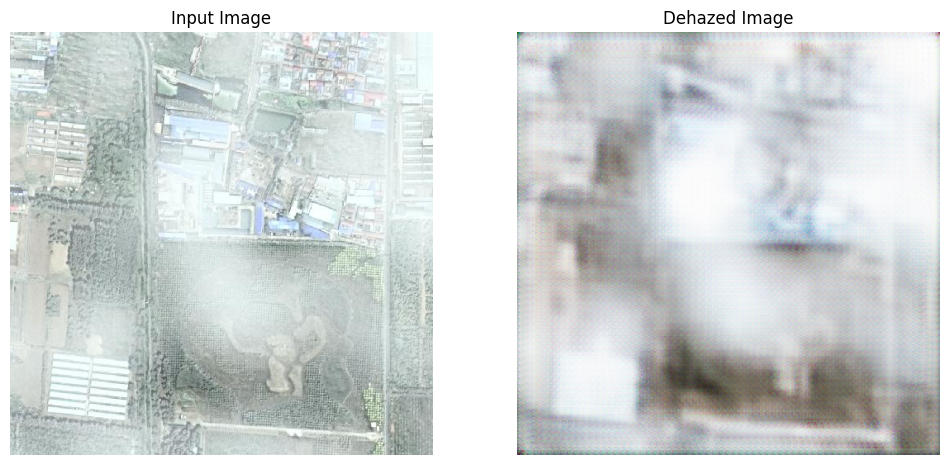

In [19]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import os
from tensorflow.keras.models import load_model

# Clear any prior TensorFlow sessions
tf.keras.backend.clear_session()

# Load the pre-trained model
model_path = r"C:\Users\Nilesh\multispectral_image_dehazing\enhanced_Nilesh_cycleGAN_dehaze.keras"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model file not found at {model_path}")

model = load_model(model_path)
print("✅ Model loaded successfully.")

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Error: Image at {image_path} could not be loaded.")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize
    img = img / 255.0  # Normalize to [0,1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to postprocess the model output
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize to [0,1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0,255]
    return output

# Function to clear memory
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main function for dehazing
def dehaze_image(input_image_path, output_image_path):
    try:
        # Validate input path
        if not os.path.exists(input_image_path):
            raise FileNotFoundError(f"❌ Input image not found: {input_image_path}")

        # Ensure output directory exists
        output_dir = os.path.dirname(output_image_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Preprocess input image
        input_image = preprocess_image(input_image_path)
        print(f"✅ Input image shape: {input_image.shape}")

        # Predict using the model
        model_output = model.predict(input_image)
        print(f"✅ Model output shape: {model_output.shape}")

        # Postprocess output
        dehazed_image = postprocess_output(model_output)

        # Save the output image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"✅ Dehazed image saved at {output_image_path}")

        # Display the images
        original_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Dehazed Image")
        plt.axis('off')

        plt.show()

        # Free memory
        clear_memory()

    except Exception as e:
        print(f"❌ Error: {e}")

# Define paths
input_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png"
output_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\output.jpg"

# Run the function
dehaze_image(input_image_path, output_image_path)


✅ Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Model output shape: (1, 256, 256, 3)
✅ Dehazed image saved successfully at C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg


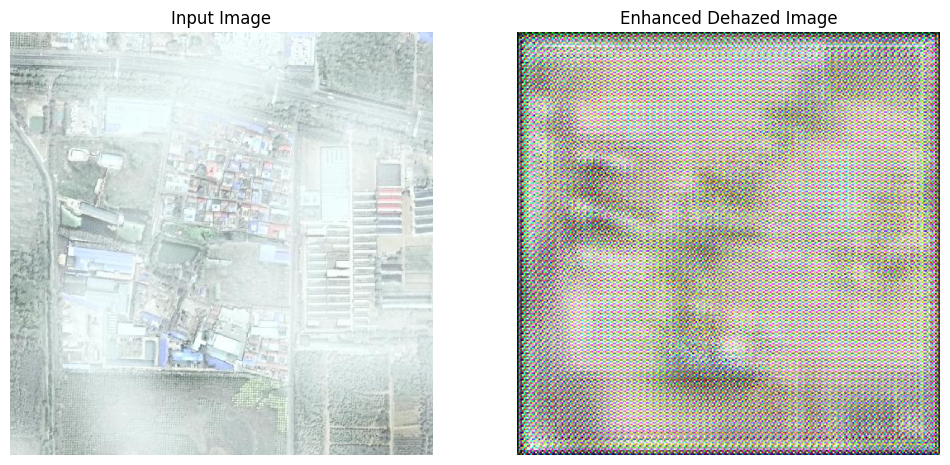

In [23]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import os
from tensorflow.keras.models import load_model

# Clear any prior TensorFlow sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("Nilesh_cycleGAN_dehaze.keras")

# Function to apply gamma correction
def gamma_correction(img, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = gamma_correction(img, gamma=1.2)  # Apply gamma correction for better brightness balance
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

def reduce_noise(image):
    # Apply Gaussian blur to reduce pixelation
    return cv2.GaussianBlur(image, (3, 3), 0.5)

def enhance_details(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening filter
    return cv2.filter2D(image, -1, kernel)


# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize to [0,1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range

    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for i in range(3):  # Apply CLAHE to each channel
        output[:, :, i] = clahe.apply(output[:, :, i])

    # Sharpening filter
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    output = cv2.filter2D(output, -1, sharpening_kernel)

    return output
"""

def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension

    # Ensure values are in the correct range
    output = np.clip(output, -1, 1)  # Clip values to expected range
    output = ((output + 1) * 127.5).astype(np.uint8)  # Convert from [-1,1] to [0,255]

    # Apply slight sharpening (helps recover details)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening filter
    output = cv2.filter2D(output, -1, kernel)

    return output
"""

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path="output.jpg"):
    try:
        # Ensure output directory exists
        output_dir = os.path.dirname(output_image_path)
        if output_dir:  # Only create directories if output path contains a folder
            os.makedirs(output_dir, exist_ok=True)

        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"✅ Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"✅ Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)

        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"✅ Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Enhanced Dehazed Image")
        plt.axis('off')

        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"❌ An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\036.png"
output_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg"  # Change to full path

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)


✅ Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
✅ Model output shape: (1, 256, 256, 3)
✅ Dehazed image saved successfully at C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg


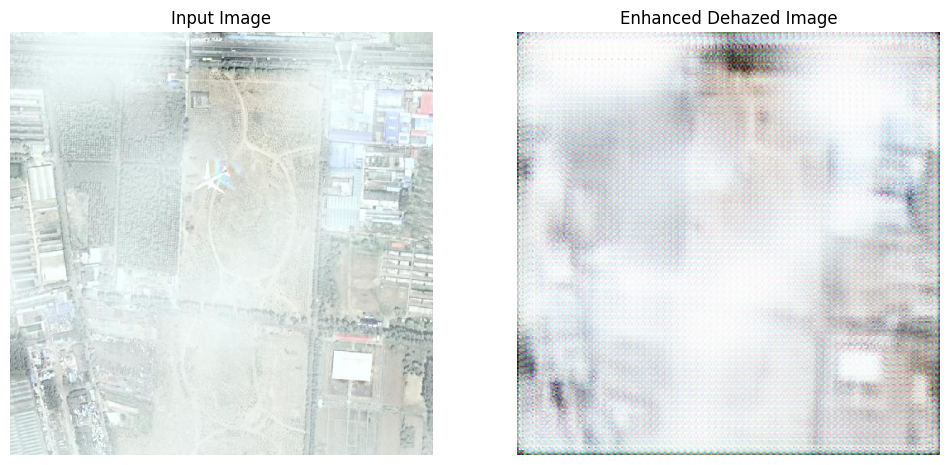

In [21]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import os
from tensorflow.keras.models import load_model

# Clear any prior TensorFlow sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("enhanced_Nilesh_cycleGAN_dehaze.keras")

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to reduce noise (fixes pixelation in dehazed image)
def reduce_noise(image):
    return cv2.GaussianBlur(image, (3, 3), 0.5)  # Small blur to smooth artifacts

# Function to enhance details (fixes blurriness in dehazed image)
def enhance_details(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening filter
    return cv2.filter2D(image, -1, kernel)

# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize to [0,1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range

    # Apply noise reduction & sharpening
    output = reduce_noise(output)
    output = enhance_details(output)
    
    return output

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path="output.jpg"):
    try:
        # Ensure output directory exists
        output_dir = os.path.dirname(output_image_path)
        if output_dir:  # Only create directories if output path contains a folder
            os.makedirs(output_dir, exist_ok=True)

        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"✅ Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"✅ Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)

        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"✅ Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Enhanced Dehazed Image")
        plt.axis('off')

        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"❌ An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\012.png'
output_image_path = r"C:\Users\Nilesh\multispectral_image_dehazing\noutput.jpg"  # Change to full path

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)


In [ ]:
import tensorflow as tf
from tqdm import tqdm
import os

# Define checkpoint directory
CHECKPOINT_DIR = "./nilesh_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define checkpoint manager
checkpoint = tf.train.Checkpoint(
    generator_G=generator_G, generator_F=generator_F, 
    discriminator_X=discriminator_X, discriminator_Y=discriminator_Y, 
    generator_G_optimizer=generator_G_optimizer, generator_F_optimizer=generator_F_optimizer, 
    discriminator_X_optimizer=discriminator_X_optimizer, discriminator_Y_optimizer=discriminator_Y_optimizer,
    epoch=tf.Variable(0)  # Track the current epoch
)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# Restore from checkpoint if available
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Restored from checkpoint:", manager.latest_checkpoint)
    start_epoch = checkpoint.epoch.numpy()  # Start from the saved epoch
else:
    start_epoch = 0  # Start from epoch 0 if no checkpoint exists

# @tf.function is used to speed up the training step
@tf.function
def train_step(real_X, real_Y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y, and F translates Y -> X.
        fake_Y = generator_G(real_X, training=True)
        fake_X = generator_F(real_Y, training=True)
        
        # Cycle: X -> Y -> X and Y -> X -> Y
        cycled_X = generator_F(fake_Y, training=True)
        cycled_Y = generator_G(fake_X, training=True)
        
        # Identity mappings (optional)
        same_X = generator_F(real_X, training=True)
        same_Y = generator_G(real_Y, training=True)
        
        # Discriminator outputs
        disc_real_X = discriminator_X(real_X, training=True)
        disc_real_Y = discriminator_Y(real_Y, training=True)
        disc_fake_X = discriminator_X(fake_X, training=True)
        disc_fake_Y = discriminator_Y(fake_Y, training=True)
        
        # Calculate losses for generators and cycle consistency
        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)
        total_cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)
        
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_Y, same_Y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_X, same_X)
        
        # Calculate discriminator losses
        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)
    
    # Calculate the gradients for generators and discriminators
    generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    
    # Apply the gradients using the optimizers
    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))
    
    return {
        "gen_G_loss": total_gen_G_loss,
        "gen_F_loss": total_gen_F_loss,
        "disc_X_loss": disc_X_loss,
        "disc_Y_loss": disc_Y_loss
    }

# Set number of epochs
EPOCHS = 4

# Outer progress bar for epochs
for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs", unit="epoch"):
    # Dictionary to accumulate loss sums for the epoch (optional, for averaging)
    epoch_losses = {"gen_G_loss": 0.0, "gen_F_loss": 0.0, "disc_X_loss": 0.0, "disc_Y_loss": 0.0}
    num_batches = 0

    # Inner progress bar for batches in the current epoch.
    for real_X, real_Y in tqdm(tf.data.Dataset.zip((Hazed_train_ds, Dehazed_train_ds)), desc="Batches", leave=False):
        losses = train_step(real_X, real_Y)
        # Accumulate losses
        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        num_batches += 1

    # Compute average losses for the epoch
    avg_losses = {key: float(val) / num_batches for key, val in epoch_losses.items()}
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS} Losses: {avg_losses}")
    
    # Save checkpoint after each epoch
    checkpoint.epoch.assign(epoch + 1)  # Increment the epoch
    manager.save()
    print(f"Checkpoint saved at epoch {epoch+1}")

# After training, save the generator model (Hazed -> Dehazed)
generator_G.save("Nilesh_cycleGAN_dehaze.h5")
print("Model saved successfully.")


In [80]:
for data in Hazed_train_ds.take(1):
    print(type(data))  # Check if it's a tuple or a single tensor
    print("Batch shape:", data.shape if hasattr(data, 'shape') else "No shape attribute")


<class 'tensorflow.python.framework.ops.EagerTensor'>
Batch shape: (16, 256, 256, 3)
